In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import os
from scipy.stats import reciprocal
from datetime import datetime

#### Wygenerowanie danych

In [2]:
m = 10000
X_moons, y_moons = make_moons(m, noise=0.08, random_state=42)

#### Wizualizacja danych

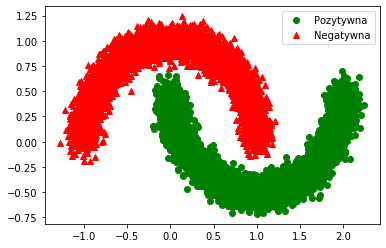

In [3]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Pozytywna")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negatywna")
plt.legend()
plt.show()

#### Dodanie wyrazu wolnego do macierzy danych (bias)

In [4]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1,1)

#### Podzial zbioru

In [5]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

#### Wygenerowanie nowych zmienych (zaleznosci nieliniowe)

In [6]:
poly = PolynomialFeatures(3)
X_train_en = poly.fit_transform(X_train)
X_test_en = poly.fit_transform(X_test)

#### Reset grafu

In [7]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [8]:
reset_graph()

#### Model

In [9]:
class LogisticRegressionMiniBatchTF:
    """
    Model regresji logistycznej z zejsciem po gradiencie z minigrupami.
    Dane wejsciowe: dane typu numpy.
    
    IN: numpy: ndarray
    
    Model zapisuje model finalny w folderze ./final_model.
    
    Optymalizacja parapetry learning_rate (losowanie z rokladu).
    
    W folderze ./tmp odkladaja sie dane do hot_start. Model liczy sie od ostatniego checkpointu
    po bledzie/przerwaniu przetwarzania.
    
    Modele porownywane na podstawie accuracy.
    
    W folderze ./log odkladaja sie logi do tensorboard.
    
    """
    def __init__(self, n_epochs, batch_size = 500, learning_rate_init = 0.1, n_iterations = 5):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate_init = learning_rate_init
        self.n_iterations = n_iterations
        self.checkpoint_path = "./tmp/model.ckpt"
        self.checkpoint_epoch_path = self.checkpoint_path + ".epoch"
        self.checkpoint_lr_path = self.checkpoint_path + ".lr"
        self.final_model_path = "./final_model/model_final.model"
        if not os.path.isdir("./tmp"):
            os.mkdir("./tmp")
        
    def random_batch(self, X_train, y_train, batch_size):
        rnd_indices = np.random.randint(0, len(X_train), batch_size)
        X_batch = X_train[rnd_indices]
        y_batch = y_train[rnd_indices]
        return X_batch, y_batch
    
    def log_dir(self, prefix=""):
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        root_logdir = "./log"
        if prefix:
            prefix += "-"
        name = prefix + "-" + now
        return "{}/{}/".format(root_logdir, name)
        
    def logistic_regression(self, X, y, initializer = None, seed = 77, learning_rate = 0.01):
        """
        Model - stworzenie grafu obliczen.
        """
        n_inputs = int(X.get_shape()[1])
        with tf.name_scope("regresja_logistyczna"):
            with tf.name_scope("model"):
                if not initializer:
                    initializer = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed = seed)
                theta = tf.Variable(initializer, name = "theta")
                logits = tf.matmul(X, theta, name = "logits")
                y_proba = tf.sigmoid(logits, name = "y_proba")
            with tf.name_scope("uczenie"):
                loss = tf.losses.log_loss(y, y_proba, scope = "strata")
                optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
                training_op = optimizer.minimize(loss)
                loss_summary = tf.summary.scalar('log_loss', loss)
            with tf.name_scope("inicjacja"):
                init = tf.global_variables_initializer()
            with tf.name_scope("zapis"):
                saver = tf.train.Saver(max_to_keep = 1000000)
        return y_proba, loss, training_op, loss_summary, init, saver
    
    def train(self, X_train, y_train, X_test, y_test):
        """
        X_* - numpy ndarray
        y_* - numpy ndarray
        """
        
        # wczytanie danych z checkpointu dla optymalizacji learning_rate
        # lub inicjalizacja danych poczatkowych
        if os.path.isfile(self.checkpoint_epoch_path):
            with open(self.checkpoint_lr_path, 'r') as f:
                dt = f.read().split(',')
                start_iterations = int(dt[0])
                lr_best = float(dt[1])
                acc_best = float(dt[2])
                print('Uczenie wznowione od przebiegu:', start_iterations + 1, '\tNajlepszy lr', lr_best, '\tNajlepsze accuracy', acc_best)
        else:
            start_iterations = 0
            lr_best = 0
            acc_best = 0
            
        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))
        n_inputs = int(X_train.shape[1])

        for iteration in range(start_iterations, self.n_iterations):

            with tf.Session() as sess:
                
                # folder logu - dane do tensorboard
                logdir = self.log_dir('log')
                file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
                
                if iteration == 0:
                    lr = self.learning_rate_init
                else:
                    lr = reciprocal(0.01, 1).rvs(random_state = iteration)

                print('Przebieg:', iteration + 1)
                print('    Logdir:', logdir)
                print('    Learning rate:', lr)

                with open(self.checkpoint_lr_path, 'w') as f:
                    f.write("%d, %s, %s" % (iteration, lr_best, acc_best))

                X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
                y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
                y_proba, loss, training_op, loss_summary, init, saver = self.logistic_regression(X, y, learning_rate = lr)                

                if os.path.isfile(self.checkpoint_epoch_path):
                    with open(self.checkpoint_epoch_path, 'rb') as f:
                        start_epoch = int(f.read())
                    print('Uczenie wznowione od epoki:', start_epoch)
                    saver.restore(sess, self.checkpoint_path)
                else:
                    start_epoch = 0
                    sess.run(init)
                
                for epoch in range(start_epoch, self.n_epochs):
                    for batch_index in range(n_batches):
                        X_batch, y_batch = self.random_batch(X_train, y_train, self.batch_size)
                        sess.run(training_op, feed_dict = {X : X_batch, y : y_batch})
                    loss_val, summary_str = sess.run([loss, loss_summary], feed_dict = {X : X_test, y : y_test})
                    file_writer.add_summary(summary_str, epoch)
                    y_proba_val = y_proba.eval(feed_dict = {X : X_test, y : y_test})
                    y_pred = (y_proba_val >= 0.5)
                    acc = accuracy_score(y_test, y_pred)
                    acc_summary = tf.summary.scalar('accuracy', acc)
                    if epoch % 100 == 0 and epoch != 0:
                        print('        Epoka:', epoch, '\tLoss:', loss_val, '\tAccuracy:', acc)
                        saver.save(sess, self.checkpoint_path)
                        with open(self.checkpoint_epoch_path, 'wb') as f:
                             f.write(b"%d" % (epoch + 1))

                y_proba_val = y_proba.eval(feed_dict = {X : X_test, y : y_test})
                y_pred = (y_proba_val >= 0.5)
                acc = accuracy_score(y_test, y_pred)

                if acc > acc_best:
                    # Problem z zapisywaniem modelu
                    saver.save(sess, self.final_model_path)
                    lr_best = lr
                    acc_best = acc

                os.remove(self.checkpoint_epoch_path)        
                print('    Final iteration accuracy:', acc)

        os.remove(self.checkpoint_lr_path)
        self.acc_best = acc_best
        self.lr_best = lr_best
        print('Final accuracy:', acc_best, 'Learning rate:', lr_best)

    def predict(self, X_score):
        """
        IN: X_score - numpy ndarray
        OUT: ndarray 
        """
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph(self.final_model_path + '.meta')
            saver.restore(sess, self.final_model_path)
            graph = tf.get_default_graph()
            X = graph.get_tensor_by_name("X:0")
            y = graph.get_tensor_by_name("y:0")
            y_proba = graph.get_tensor_by_name("regresja_logistyczna/model/y_proba:0")
            feed_dict = {X : X_score}
            y_proba_val = sess.run(y_proba, feed_dict = {X : X_score})
            return (y_proba_val >= 0.5)

In [10]:
model = LogisticRegressionMiniBatchTF(n_epochs = 501, n_iterations = 10, learning_rate_init = 0.85)

In [11]:
model.train(X_train = X_train_en, y_train = y_train, X_test = X_test_en, y_test = y_test)

Przebieg: 1
    Logdir: ./log/log--20200927205434/
    Learning rate: 0.85
        Epoka: 100 	Loss: 0.015833488 	Accuracy: 1.0
        Epoka: 200 	Loss: 0.009517016 	Accuracy: 1.0
        Epoka: 300 	Loss: 0.0070255315 	Accuracy: 1.0
        Epoka: 400 	Loss: 0.0056434846 	Accuracy: 1.0
        Epoka: 500 	Loss: 0.0047692927 	Accuracy: 1.0
    Final iteration accuracy: 1.0
Przebieg: 2
    Logdir: ./log/log--20200927205515/
    Learning rate: 0.06824078427098831
        Epoka: 100 	Loss: 0.09499588 	Accuracy: 0.9715
        Epoka: 200 	Loss: 0.059978753 	Accuracy: 0.988
        Epoka: 300 	Loss: 0.045141023 	Accuracy: 0.993
        Epoka: 400 	Loss: 0.036680073 	Accuracy: 0.9945
        Epoka: 500 	Loss: 0.031206554 	Accuracy: 0.9975
    Final iteration accuracy: 0.9975
Przebieg: 3
    Logdir: ./log/log--20200927205643/
    Learning rate: 0.07447144904083068
        Epoka: 100 	Loss: 0.089835435 	Accuracy: 0.973
        Epoka: 200 	Loss: 0.05650984 	Accuracy: 0.9885
        Epoka: 300 

#### Ewaluacja (zbior testowy)

In [12]:
y_pred = model.predict(X_test_en)

INFO:tensorflow:Restoring parameters from ./final_model/model_final.model


In [13]:
accuracy_score(y_pred, y_test)

1.0

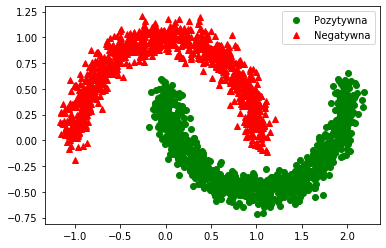

In [14]:
y_pred_idx = y_pred.reshape(-1) 
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Pozytywna")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negatywna")
plt.legend()
plt.show()